# Deep Learning for Sentiment Analysis on the Yelp Dataset

## Imports

First, let's make sure that we have all the necessary libraries.

In [106]:
%pip install --upgrade tensorflow matplotlib pandas folium kaggle scikit-learn seaborn keras


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


The imports below are all ML/DL related.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

The imports below are mostly utility imports.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
import json
import os
import math

## Data retrieval from Kaggle

Simply copy-paste your username and key below and run all the cells below to get the data.

In [109]:
os.environ['KAGGLE_USERNAME'] = "x"
os.environ['KAGGLE_KEY'] = "x"

In [110]:
!kaggle datasets download -d yelp-dataset/yelp-dataset || echo "You probably forgot to insert you credentials in the code cell above!"

401 - Unauthorized
You probably forgot to insert you credentials in the code cell above!


The OR (`||`) in the cells below is so that one can run all the cells multiple times, without having to worry about skipping these two (which would impede the process, seeing as they would return an error).

In [111]:
!mkdir yelp-data || echo "Directory is ready."

mkdir: yelp-data: File exists
Directory is ready.


In [112]:
!echo "N" | unzip -d yelp-data yelp-dataset.zip || echo "Data is ready." # the initial echo is to tell unzip to not replace any file if the files exist already

Archive:  yelp-dataset.zip
replace yelp-data/Dataset_User_Agreement.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Data examination

### Let's define some useful functions...

In [3]:
# adjust the kwarg 'max_nl' depending on how much time you're willing to wait and how much RAM is available (leave None if you want to read the whole file)
def read_to_dataframe(file, max_nl=None):
  with open(file, 'r') as f:
    data = [json.loads(line) for line in f] if max_nl is None else [json.loads(next(f)) for _ in range(max_nl)]

  return pd.DataFrame(data)

### ...define some useful variables

In [4]:
data_dir = "yelp-data/" # splitting data up like this might be useful for later (in case i want to use other files)

### ... and turn our data into a pandas DataFrame for further examination.

In [5]:
review_file = "yelp_academic_dataset_review.json"

In [6]:
review_df = read_to_dataframe(data_dir + review_file, max_nl=100_000)

Great! Let's see what we're dealing with.

In [117]:
review_df.head() # to get an idea as to what we're dealing with

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


It seems that the two key columns are 'stars' and 'text', the former as a label and the latter as our features. The 'useful', 'funny' and 'cool' columns also look interesting, but it seems like they're more about the review per se than the place being reviewed and are made a posteriori (i.e. after the review has already been made and the rating has been assigned, check [here](https://aghenai.github.io/assets/publications/Amira_Ghenai_Final_Report.pdf)), so we can't really use them for much.

In [118]:
review_df.drop(columns=['useful', 'funny', 'cool'], inplace=True) # it's no use carrying useless data around...

Let's get some extra information.

In [119]:
review_df.info() # all entries are non-null! 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   review_id    100000 non-null  object 
 1   user_id      100000 non-null  object 
 2   business_id  100000 non-null  object 
 3   stars        100000 non-null  float64
 4   text         100000 non-null  object 
 5   date         100000 non-null  object 
dtypes: float64(1), object(5)
memory usage: 4.6+ MB


No nulls anywhere, wonderful news! Let's quickly check out the statistics of the stars column.

In [120]:
review_df.describe()

,stars
count,100000.000000
mean,3.842910
std,1.354729
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


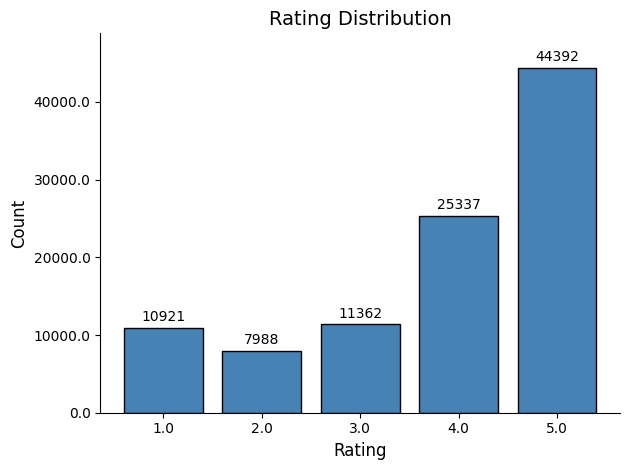

In [121]:
# sort the ratings in ascending order
sorted_ratings = review_df['stars'].value_counts().sort_index()

# Create a bar plot
fig, ax = plt.subplots()

ax.bar(sorted_ratings.index, sorted_ratings.values, color='steelblue', edgecolor='black')

# set plot title and labels
ax.set_title('Rating Distribution', fontsize=14)
ax.set_xlabel('Rating', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# customize the tick labels and axis limits
ax.set_xticks(sorted_ratings.index)
ax.set_xticklabels(sorted_ratings.index, fontsize=10)

ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
ax.set_yticklabels(ax.get_yticks(), fontsize=10)
ax.set_ylim(0, sorted_ratings.max() * 1.1)

# Remove spines and add grid lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add data labels above each bar
for x, y in zip(sorted_ratings.index, sorted_ratings.values):
    ax.text(x, y + 0.02 * sorted_ratings.max(), str(y), ha='center', fontsize=10)

# Adjust the figure layout
fig.tight_layout()

# Show the plot
plt.show()


Interesting distribution. It seems that most of the reviews are positive, and a reasonable amount of them as positive as they can be!

### Let's inspect the data some more, for the fun of it.

I don't like the identifiers we're currently working with, and would rather like to see the names of the various businesses and their locations.

In [7]:
business_file = "yelp_academic_dataset_business.json"

business_df = read_to_dataframe(data_dir + business_file) # no need to set a limit (the file is 113MB large)
business_df.drop(["stars"], axis=1, inplace=True) # this is the rating of the businesses (we don't care about that)

In [8]:
rich_df = pd.merge(review_df, business_df, on="business_id")

Ok, let's see what this "rich" data gives us...

In [124]:
rich_df.head()

,review_id,user_id,business_id,stars,text,date,name,address,city,state,postal_code,latitude,longitude,review_count,is_open,attributes,categories,hours
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
1,VJxlBnJmCDIy8DFG0kjSow,Iaee7y6zdSB3B-kRCo4z1w,XQfwVwDr-v0ZS3_CbbE5Xw,2.0,This is the second time we tried turning point...,2017-05-13 17:06:55,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
2,S6pQZQocMB1WHMjTRbt77A,ejFxLGqQcWNLdNByJlIhnQ,XQfwVwDr-v0ZS3_CbbE5Xw,4.0,The place is cute and the staff was very frien...,2017-08-08 00:58:18,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
3,WqgTKVqWVHDHjnjEsBvUgg,f7xa0p_1V9lx53iIGN5Sug,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,We came on a Saturday morning after waiting a ...,2017-11-19 02:20:23,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
4,M0wzFFb7pefOPcxeRVbLag,dCooFVCk8M1nVaQqcfTL3Q,XQfwVwDr-v0ZS3_CbbE5Xw,2.0,"Mediocre at best. The decor is very nice, and ...",2017-09-09 17:49:47,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."


Perfect: we know get some extra information about the business. Everything is much more human readable now and ameanable to further exploration. I only intend to take a look at a geographical visualization, but the possibilites are endless. I encourage you to explore them, if you wish.

Graphically speaking, we can use the `folium` library.

In [125]:
import folium

fol_fig = folium.Figure(width=1000, height=600)

# Create a map object centered at a specific location (e.g., the geographical center of North America (we know the data is from USA and Canada))
map_obj = folium.Map(location=[39.7392, -104.9903], zoom_start=4, tiles='Stamen Toner').add_to(fol_fig)

sampled_df = rich_df.sample(n=1000) # to speed up execution (up to 1000 works fine, above that it starts to slow down significantly)
# Iterate over your dataset and add markers for each data point
for index, row in sampled_df.iterrows():
    # Extract the latitude and longtude values from your dataframe
    latitude = row['latitude']
    longitude = row['longitude']
    
    # Add a marker to the map for each data point
    folium.Marker([latitude, longitude]).add_to(map_obj)

# Display the map
map_obj

So it seems that our data is mostly made up of businesses on the east and west coasts of the USA, and then Canada. That's interesting (and not particularly surprising).

Now, onto more interesting things!

## Prepare the data 

### Let's define some useful functions...

In [10]:
def create_datasets(df, feature_columns, label_column, train_size, test_size, random_state=None):
    X = df[feature_columns]
    y = df[label_column]

    # we use stratification to mantain similar proportions across the various splits (the distribution is quite asymmetrical, after all)
    X_train, X_test_val, y_train, y_test_val = train_test_split(
        X, y, train_size=train_size, stratify=y, random_state=random_state)

    X_val, X_test, y_val, y_test = train_test_split(
        X_test_val, y_test_val, test_size=test_size, stratify=y_test_val, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

def prepare_for_model(train_dataset, val_dataset, test_dataset, m, preprocess_fn, batch_size=64):
    # apply the preprocessing pipeline to the datasets
    train_dataset_prepepared = train_dataset.map(
        lambda review, label: (preprocess_fn(review), label))
    val_dataset_prepared = val_dataset.map(
        lambda review, label: (preprocess_fn(review), label))
    test_dataset_prepared = test_dataset.map(
        lambda review, label: (preprocess_fn(review), label))

    # shuffle and batch the training dataset
    train_dataset_prepepared = train_dataset_prepepared.shuffle(m).batch(batch_size)

    # batch the validation and testing datasets
    val_dataset_prepared = val_dataset_prepared.batch(batch_size)
    test_dataset_prepared = test_dataset_prepared.batch(batch_size)

    return train_dataset_prepepared, val_dataset_prepared, test_dataset_prepared


### ... and some useful variables, as usual.

In [12]:
vocabulary_size = 30_000
train_size = 0.7 # the percentage of data reserved for training
test_size = 0.5 # the percentage of data reserved for testing (from the data that remains)
n_epochs = 10 # adjust this if the model trains too slowly (or modify model parameters as desired...)

### Ok, now on to data preparation.

In [128]:
# only get data from the review DataFrame (the one in the rich_df is more for exploratory purposes)
X_train, X_val, X_test, y_train, y_val, y_test = create_datasets(
    review_df, 'text', 'stars', train_size, test_size, random_state=42) # the random state is set for reproducibility

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (70000,) (70000,)
Validation set shape: (15000,) (15000,)
Testing set shape: (15000,) (15000,)


We need to make sure that the data is in a format that `tensorflow`  now can work with.

In [129]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Also, we need to define the function we're going to use to preprocess the data and prepare it for the model, which, thanks to keras, is incredibly easy: the `TextVectorization` layer is capable of processing textual data E2E, i.e. from standardization, to tokenization and to vectorization!

In [130]:
# it's almost magical...
text_vectorization_1gram = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_mode='multi_hot',
    standardize='lower_and_strip_punctuation',
    split='whitespace',
)

Before moving on, we need to build the vocabulary, i.e. we need to fundamentally build the vector space that we'll operate in.

In [131]:
# this might take a while (~20s)
text_vectorization_1gram.adapt(train_dataset.map(lambda review, label: review))

In [132]:
text_vectorization_1gram.get_vocabulary()

['[UNK]',
 'the',
 'and',
 'a',
 'i',
 'to',
 'was',
 'of',
 'is',
 'it',
 'for',
 'in',
 'my',
 'we',
 'with',
 'that',
 'but',
 'this',
 'they',
 'on',
 'you',
 'had',
 'have',
 'not',
 'were',
 'food',
 'so',
 'are',
 'good',
 'at',
 'place',
 'great',
 'be',
 'as',
 'very',
 'there',
 'all',
 'our',
 'if',
 'here',
 'out',
 'me',
 'service',
 'just',
 'like',
 'its',
 'time',
 'one',
 'get',
 'from',
 'their',
 'back',
 'would',
 'when',
 'or',
 'an',
 'go',
 'up',
 'really',
 'about',
 'which',
 'will',
 'been',
 'also',
 'some',
 'what',
 'no',
 'only',
 'more',
 'she',
 'can',
 'your',
 'us',
 'nice',
 'best',
 'got',
 'by',
 'he',
 'well',
 'because',
 'them',
 'dont',
 'even',
 'too',
 'staff',
 'other',
 'ordered',
 'love',
 'ive',
 'im',
 'friendly',
 'has',
 'delicious',
 'always',
 'after',
 'order',
 'do',
 'restaurant',
 'little',
 'than',
 'came',
 'chicken',
 'definitely',
 'try',
 'didnt',
 'first',
 'menu',
 'did',
 'went',
 'could',
 'never',
 'amazing',
 'much',
 '

Great, now we can finally turn the data in a format accepted by the model.

In [133]:
train_dataset_prep_1gram, val_dataset_prep_1gram, test_dataset_prep_1gram = prepare_for_model(
    train_dataset, val_dataset, test_dataset, len(X_train), text_vectorization_1gram)

Let's see if everything worked.

In [134]:
for inputs, targets in train_dataset_prep_1gram:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)

    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)

    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

2023-06-17 17:32:41.654412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 44543 of 70000
2023-06-17 17:32:47.389732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


inputs.shape: (64, 30000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (64,)
targets.dtype: <dtype: 'float64'>
inputs[0]: tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(30000,), dtype=float32)
targets[0]: tf.Tensor(2.0, shape=(), dtype=float64)


Looks good!

## Let's try a Bag-of-Words approach 

### As above, the first cell will contain some useful functions.

In [135]:
def create_bow_model(input_dim):
    input = layers.Input(shape=(input_dim,))

    # the network below is pretty small, mostly because the previous one (which was quite a bit bigger) simply kept crashing the Colab kernel
    x = layers.Dense(256, activation='relu')(input)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    output = layers.Dense(1)(x)

    model = keras.Model(inputs=input, outputs=output)

    # I'm going to treat this as a regression problem (although it could be seens as a classification) because, as far as sentiment analysis is concerned, it should allow for a more nuanced opinion
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mse'])

    return model

def plot_training_curves(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()

### Let us begin with the simplest possible model: a 1-gram model.

The first approach we're going to try is a simple Bag-of-Words approach, i.e. we'll treat the various tokens (in our case the single words) as elements of a set (i.e. the bag of words) and we'll ignore the order in which they're presented. There will be time for more complicated models later on. For now, we simply want a baseline.

In [136]:
# the model we created is 1-gram, i.e. each word represents a single element in the set
model_1gram = create_bow_model(vocabulary_size)

In [137]:
model_1gram.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense_24 (Dense)            (None, 256)               7680256   
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 128)               32896     
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 dropout_20 (Dropout)        (None, 64)                0   

In [138]:
callbacks = [
    keras.callbacks.ModelCheckpoint("model_bow_1gram", save_best_only=True)
]

history_1gram = model_1gram.fit(
    # one could .cache() this data to speed up training, but I didn't do it to take up less RAM
    train_dataset_prep_1gram,
    validation_data=val_dataset_prep_1gram,
    epochs=n_epochs,
    callbacks=callbacks,
    )

Epoch 1/10


2023-06-17 17:32:57.912271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 45261 of 70000


   8/1094 [..............................] - ETA: 19s - loss: 12.1659 - mse: 12.1659  

2023-06-17 17:33:03.491413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - ETA: 0s - loss: 1.6927 - mse: 1.6927INFO:tensorflow:Assets written to: model_bow_1gram/assets


INFO:tensorflow:Assets written to: model_bow_1gram/assets


1094/1094 [==============================] - 38s 20ms/step - loss: 1.6927 - mse: 1.6927 - val_loss: 0.6555 - val_mse: 0.6555
Epoch 2/10


2023-06-17 17:33:35.501779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 45116 of 70000


   9/1094 [..............................] - ETA: 16s - loss: 1.0262 - mse: 1.0262  

2023-06-17 17:33:41.262166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - ETA: 0s - loss: 0.9659 - mse: 0.9659INFO:tensorflow:Assets written to: model_bow_1gram/assets


INFO:tensorflow:Assets written to: model_bow_1gram/assets


1094/1094 [==============================] - 39s 21ms/step - loss: 0.9659 - mse: 0.9659 - val_loss: 0.6351 - val_mse: 0.6351
Epoch 3/10


2023-06-17 17:34:14.514971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 44431 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 0.7840 - mse: 0.7840

2023-06-17 17:34:20.427204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - ETA: 0s - loss: 0.7383 - mse: 0.7383INFO:tensorflow:Assets written to: model_bow_1gram/assets


INFO:tensorflow:Assets written to: model_bow_1gram/assets


1094/1094 [==============================] - 38s 20ms/step - loss: 0.7383 - mse: 0.7383 - val_loss: 0.5841 - val_mse: 0.5841
Epoch 4/10


2023-06-17 17:34:52.614993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 46698 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 0.6321 - mse: 0.6321

2023-06-17 17:34:57.762918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1093/1094 [============================>.] - ETA: 0s - loss: 0.6097 - mse: 0.6097INFO:tensorflow:Assets written to: model_bow_1gram/assets


INFO:tensorflow:Assets written to: model_bow_1gram/assets


1094/1094 [==============================] - 37s 20ms/step - loss: 0.6097 - mse: 0.6097 - val_loss: 0.5480 - val_mse: 0.5480
Epoch 5/10


2023-06-17 17:35:30.070172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 45641 of 70000


  13/1094 [..............................] - ETA: 15s - loss: 0.5684 - mse: 0.5684

2023-06-17 17:35:35.542058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - ETA: 0s - loss: 0.5259 - mse: 0.5259INFO:tensorflow:Assets written to: model_bow_1gram/assets


INFO:tensorflow:Assets written to: model_bow_1gram/assets


1094/1094 [==============================] - 38s 21ms/step - loss: 0.5259 - mse: 0.5259 - val_loss: 0.5322 - val_mse: 0.5322
Epoch 6/10


2023-06-17 17:36:08.089346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 44694 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 0.4359 - mse: 0.4359

2023-06-17 17:36:13.774070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - ETA: 0s - loss: 0.4544 - mse: 0.4544INFO:tensorflow:Assets written to: model_bow_1gram/assets


INFO:tensorflow:Assets written to: model_bow_1gram/assets


1094/1094 [==============================] - 38s 20ms/step - loss: 0.4544 - mse: 0.4544 - val_loss: 0.5255 - val_mse: 0.5255
Epoch 7/10


2023-06-17 17:36:46.091384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 45356 of 70000


   9/1094 [..............................] - ETA: 16s - loss: 0.3504 - mse: 0.3504  

2023-06-17 17:36:51.798900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1093/1094 [============================>.] - ETA: 0s - loss: 0.4000 - mse: 0.4000INFO:tensorflow:Assets written to: model_bow_1gram/assets


INFO:tensorflow:Assets written to: model_bow_1gram/assets


1094/1094 [==============================] - 39s 21ms/step - loss: 0.4000 - mse: 0.4000 - val_loss: 0.5248 - val_mse: 0.5248
Epoch 8/10


2023-06-17 17:37:25.003761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 45136 of 70000


  13/1094 [..............................] - ETA: 15s - loss: 0.3641 - mse: 0.3641

2023-06-17 17:37:30.843138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 38s 20ms/step - loss: 0.3687 - mse: 0.3687 - val_loss: 0.5251 - val_mse: 0.5251
Epoch 9/10


2023-06-17 17:38:03.248432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 45889 of 70000


  12/1094 [..............................] - ETA: 16s - loss: 0.3434 - mse: 0.3434

2023-06-17 17:38:08.783086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - ETA: 0s - loss: 0.3370 - mse: 0.3370INFO:tensorflow:Assets written to: model_bow_1gram/assets


INFO:tensorflow:Assets written to: model_bow_1gram/assets


1094/1094 [==============================] - 39s 21ms/step - loss: 0.3370 - mse: 0.3370 - val_loss: 0.5241 - val_mse: 0.5241
Epoch 10/10


2023-06-17 17:38:42.119109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 45579 of 70000


  10/1094 [..............................] - ETA: 19s - loss: 0.3036 - mse: 0.3036

2023-06-17 17:38:47.639239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - ETA: 0s - loss: 0.3106 - mse: 0.3106INFO:tensorflow:Assets written to: model_bow_1gram/assets


INFO:tensorflow:Assets written to: model_bow_1gram/assets


1094/1094 [==============================] - 38s 21ms/step - loss: 0.3106 - mse: 0.3106 - val_loss: 0.5194 - val_mse: 0.5194


Not too bad, it seems (and it trains lightning fast). Let's look at the training and validation curves.

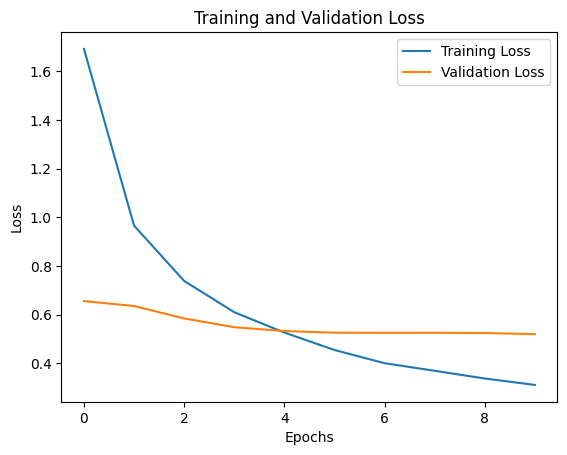

In [139]:
plot_training_curves(history_1gram)

It seems like some light overfitting happened in the latter epochs. The validation loss bounces around 0.6, so it seems to indicate that that's about as well as our model can perform. Overall, the result is not the worst (our rating will, seeing as we get a mean error of ~0.72 (sqrt(0.52))).

For now, though, let's experiment with a 2-gram model (i.e. our tokens are going to be made up of two words each, so we'll inject some local order information into it).

### Let's add some local order information: a bigram (2-gram) model.

In [140]:
text_vectorization_2gram = layers.TextVectorization(
    ngrams=2, # yes, it is that simple!
    max_tokens=vocabulary_size,
    output_mode='multi_hot',
    standardize='lower_and_strip_punctuation',
    split='whitespace',
)

Naturally, we need to rebuild the vocabulary (we're adding some new basis vectors after all).

In [141]:
text_vectorization_2gram.adapt(train_dataset.map(lambda review, label: review))

In [142]:
text_vectorization_2gram.get_vocabulary() # notice how we now have basis vectors made up of two words (e.g "the hotel")

['[UNK]',
 'the',
 'and',
 'a',
 'i',
 'to',
 'was',
 'of',
 'is',
 'it',
 'for',
 'in',
 'my',
 'we',
 'with',
 'that',
 'but',
 'this',
 'they',
 'on',
 'you',
 'had',
 'have',
 'not',
 'were',
 'food',
 'so',
 'are',
 'good',
 'at',
 'place',
 'great',
 'be',
 'as',
 'very',
 'there',
 'all',
 'our',
 'if',
 'here',
 'out',
 'me',
 'of the',
 'it was',
 'service',
 'and the',
 'just',
 'like',
 'its',
 'time',
 'one',
 'get',
 'in the',
 'from',
 'their',
 'back',
 'would',
 'when',
 'or',
 'an',
 'go',
 'up',
 'really',
 'about',
 'which',
 'this place',
 'will',
 'been',
 'on the',
 'also',
 'some',
 'what',
 'i was',
 'and i',
 'no',
 'the food',
 'only',
 'more',
 'she',
 'can',
 'your',
 'us',
 'nice',
 'best',
 'got',
 'for a',
 'by',
 'he',
 'to the',
 'for the',
 'well',
 'because',
 'them',
 'dont',
 'even',
 'too',
 'staff',
 'other',
 'ordered',
 'love',
 'ive',
 'im',
 'i had',
 'friendly',
 'has',
 'delicious',
 'always',
 'after',
 'order',
 'do',
 'restaurant',
 'is a

Just as naturally, we need to re-prepare the data!

In [143]:
train_dataset_prep_2gram, val_dataset_prep_2gram, test_dataset_prep_2gram = prepare_for_model(
    train_dataset, val_dataset, test_dataset, len(X_train), text_vectorization_2gram)

We use the exact same architecture: we want to see whether using bigrams helps, after all, and changing architecture would only impede this ascertainment.

In [144]:
model_2gram = create_bow_model(vocabulary_size)

In [145]:
model_2gram.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense_28 (Dense)            (None, 256)               7680256   
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_29 (Dense)            (None, 128)               32896     
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 64)                8256      
                                                                 
 dropout_23 (Dropout)        (None, 64)                0   

In [146]:
callbacks = [
    keras.callbacks.ModelCheckpoint("model_bow_2gram", save_best_only=True)
]

history_2gram = model_2gram.fit(
    # one could .cache() this data to speed up training, but I didn't do it to take up less RAM
    train_dataset_prep_2gram,
    validation_data=val_dataset_prep_2gram,
    epochs=n_epochs,
    callbacks=callbacks,
    )

Epoch 1/10


2023-06-17 17:39:42.857442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 41259 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 11.5958 - mse: 11.5958

2023-06-17 17:39:49.748989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1093/1094 [============================>.] - ETA: 0s - loss: 1.8868 - mse: 1.8868INFO:tensorflow:Assets written to: model_bow_2gram/assets


INFO:tensorflow:Assets written to: model_bow_2gram/assets


1094/1094 [==============================] - 39s 20ms/step - loss: 1.8871 - mse: 1.8871 - val_loss: 0.7073 - val_mse: 0.7073
Epoch 2/10


2023-06-17 17:40:21.765996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 42831 of 70000


  11/1094 [..............................] - ETA: 18s - loss: 1.1652 - mse: 1.1652

2023-06-17 17:40:28.247422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1093/1094 [============================>.] - ETA: 0s - loss: 1.0010 - mse: 1.0010INFO:tensorflow:Assets written to: model_bow_2gram/assets


INFO:tensorflow:Assets written to: model_bow_2gram/assets


1094/1094 [==============================] - 39s 20ms/step - loss: 1.0008 - mse: 1.0008 - val_loss: 0.6185 - val_mse: 0.6185
Epoch 3/10


2023-06-17 17:41:00.565511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 42769 of 70000


  12/1094 [..............................] - ETA: 16s - loss: 0.8082 - mse: 0.8082

2023-06-17 17:41:07.076207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1093/1094 [============================>.] - ETA: 0s - loss: 0.7220 - mse: 0.7220INFO:tensorflow:Assets written to: model_bow_2gram/assets


INFO:tensorflow:Assets written to: model_bow_2gram/assets


1094/1094 [==============================] - 39s 20ms/step - loss: 0.7219 - mse: 0.7219 - val_loss: 0.5330 - val_mse: 0.5330
Epoch 4/10


2023-06-17 17:41:39.134353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 41753 of 70000


   9/1094 [..............................] - ETA: 15s - loss: 0.6275 - mse: 0.6275  

2023-06-17 17:41:46.150865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1093/1094 [============================>.] - ETA: 0s - loss: 0.5644 - mse: 0.5644INFO:tensorflow:Assets written to: model_bow_2gram/assets


INFO:tensorflow:Assets written to: model_bow_2gram/assets


1094/1094 [==============================] - 40s 21ms/step - loss: 0.5645 - mse: 0.5645 - val_loss: 0.5095 - val_mse: 0.5095
Epoch 5/10


2023-06-17 17:42:18.778256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 40602 of 70000


  13/1094 [..............................] - ETA: 15s - loss: 0.4652 - mse: 0.4652

2023-06-17 17:42:25.758492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - ETA: 0s - loss: 0.4678 - mse: 0.4678INFO:tensorflow:Assets written to: model_bow_2gram/assets


INFO:tensorflow:Assets written to: model_bow_2gram/assets


1094/1094 [==============================] - 39s 20ms/step - loss: 0.4678 - mse: 0.4678 - val_loss: 0.4896 - val_mse: 0.4896
Epoch 6/10


2023-06-17 17:42:57.971042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 41961 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 0.4258 - mse: 0.4258

2023-06-17 17:43:04.748533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1093/1094 [============================>.] - ETA: 0s - loss: 0.3961 - mse: 0.3961INFO:tensorflow:Assets written to: model_bow_2gram/assets


INFO:tensorflow:Assets written to: model_bow_2gram/assets


1094/1094 [==============================] - 39s 20ms/step - loss: 0.3961 - mse: 0.3961 - val_loss: 0.4590 - val_mse: 0.4590
Epoch 7/10


2023-06-17 17:43:36.564089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 42466 of 70000


  13/1094 [..............................] - ETA: 15s - loss: 0.3780 - mse: 0.3780

2023-06-17 17:43:43.216645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 39s 20ms/step - loss: 0.3449 - mse: 0.3449 - val_loss: 0.4755 - val_mse: 0.4755
Epoch 8/10


2023-06-17 17:44:15.468185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 42723 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 0.3490 - mse: 0.3490

2023-06-17 17:44:21.899715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 38s 20ms/step - loss: 0.3070 - mse: 0.3070 - val_loss: 0.4754 - val_mse: 0.4754
Epoch 9/10


2023-06-17 17:44:53.767024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 42153 of 70000


   9/1094 [..............................] - ETA: 16s - loss: 0.2582 - mse: 0.2582  

2023-06-17 17:45:00.512836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 39s 20ms/step - loss: 0.2767 - mse: 0.2767 - val_loss: 0.4684 - val_mse: 0.4684
Epoch 10/10


2023-06-17 17:45:32.359010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 42043 of 70000


  13/1094 [..............................] - ETA: 15s - loss: 0.2470 - mse: 0.2470

2023-06-17 17:45:39.226500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 39s 21ms/step - loss: 0.2568 - mse: 0.2568 - val_loss: 0.4733 - val_mse: 0.4733


Even simply looking at the numbers, this approach seems quite a bit better!

As above, let's take a look at the training and validation curves.

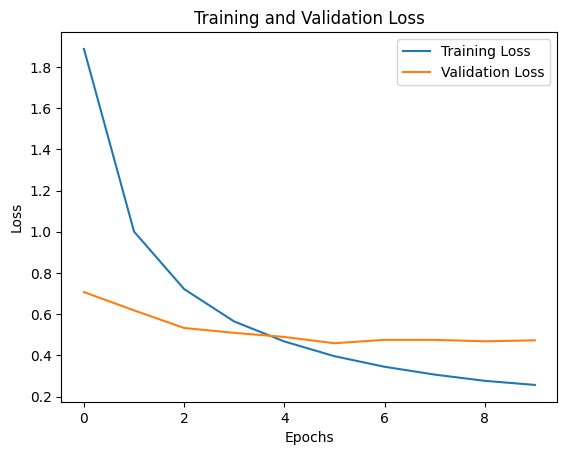

In [147]:
plot_training_curves(history_2gram)

Indeed, the graph seems to confirm the improvement, even though they still look quite similar. But we don't need to rely on our eyes, do we? Let's evaluate them and see which one wins!

In [148]:
loss_1, mse_1= model_1gram.evaluate(test_dataset_prep_1gram)
print(f"1-gram Model - MSE: {mse_1:.4f}")

loss_2, mse_2 = model_2gram.evaluate(test_dataset_prep_2gram)
print(f"2-gram model 2 - MSE: {mse_2:.4f}")

235/235 [==============================] - 5s 19ms/step - loss: 0.5093 - mse: 0.5093
1-gram Model - MSE: 0.5093
235/235 [==============================] - 5s 20ms/step - loss: 0.4507 - mse: 0.4507
2-gram model 2 - MSE: 0.4507


The 2-gram model is almost 10% better: good news!

But we can still do better without acting on the architecture: by inspecting the vocabularies created by the `TextVectorization` layer we see quite a few words which have zero influence on sentiment (i.e. words like "the", "i", etc.). How do we make sure that these words matter very little? Simple: use TF-IDF!

### Complicating matters further: adding TF-IDF to our bigram model.

In [150]:
# we have the very convenient TextVectorizatoin layer for preprocessing!
text_vectorization_tfidf = layers.TextVectorization(
    ngrams=2,
    max_tokens=vocabulary_size,
    output_mode='tf_idf', # once again, it's that simple
    standardize='lower_and_strip_punctuation',
    split='whitespace',
)

In [151]:
text_vectorization_tfidf.adapt(train_dataset.map(lambda review, label: review))

In [152]:
text_vectorization_tfidf.get_vocabulary()

['[UNK]',
 'the',
 'and',
 'a',
 'i',
 'to',
 'was',
 'of',
 'is',
 'it',
 'for',
 'in',
 'my',
 'we',
 'with',
 'that',
 'but',
 'this',
 'they',
 'on',
 'you',
 'had',
 'have',
 'not',
 'were',
 'food',
 'so',
 'are',
 'good',
 'at',
 'place',
 'great',
 'be',
 'as',
 'very',
 'there',
 'all',
 'our',
 'if',
 'here',
 'out',
 'me',
 'of the',
 'it was',
 'service',
 'and the',
 'just',
 'like',
 'its',
 'time',
 'one',
 'get',
 'in the',
 'from',
 'their',
 'back',
 'would',
 'when',
 'or',
 'an',
 'go',
 'up',
 'really',
 'about',
 'which',
 'this place',
 'will',
 'been',
 'on the',
 'also',
 'some',
 'what',
 'i was',
 'and i',
 'no',
 'the food',
 'only',
 'more',
 'she',
 'can',
 'your',
 'us',
 'nice',
 'best',
 'got',
 'for a',
 'by',
 'he',
 'to the',
 'for the',
 'well',
 'because',
 'them',
 'dont',
 'even',
 'too',
 'staff',
 'other',
 'ordered',
 'love',
 'ive',
 'im',
 'i had',
 'friendly',
 'has',
 'delicious',
 'always',
 'after',
 'order',
 'do',
 'restaurant',
 'is a

In [153]:
train_dataset_prep_tfidf, val_dataset_prep_tfidf, test_dataset_prep_tfidf = prepare_for_model(
    train_dataset, val_dataset, test_dataset, len(X_train), text_vectorization_tfidf)

In [154]:
model_tfidf = create_bow_model(vocabulary_size)

In [155]:
model_tfidf.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense_32 (Dense)            (None, 256)               7680256   
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                                 
 dense_33 (Dense)            (None, 128)               32896     
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dropout_26 (Dropout)        (None, 64)                0   

In [156]:
callbacks = [
    keras.callbacks.ModelCheckpoint("model_bow_2gram_tfidf", save_best_only=True)
]

history_tfidf = model_tfidf.fit(
    # one could .cache() this data to speed up training, but I didn't do it to take up less RAM
    train_dataset_prep_tfidf,
    validation_data=val_dataset_prep_tfidf,
    epochs=n_epochs,
    callbacks=callbacks,
    )

Epoch 1/10


2023-06-17 17:47:58.629135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 41127 of 70000


  13/1094 [..............................] - ETA: 15s - loss: 23.9641 - mse: 23.9641

2023-06-17 17:48:05.598842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1093/1094 [============================>.] - ETA: 0s - loss: 3.0941 - mse: 3.0941INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


1094/1094 [==============================] - 40s 21ms/step - loss: 3.0932 - mse: 3.0932 - val_loss: 0.7141 - val_mse: 0.7141
Epoch 2/10


2023-06-17 17:48:38.357057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 41082 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 1.4511 - mse: 1.4511

2023-06-17 17:48:45.314314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1093/1094 [============================>.] - ETA: 0s - loss: 1.1799 - mse: 1.1799INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


1094/1094 [==============================] - 39s 20ms/step - loss: 1.1795 - mse: 1.1795 - val_loss: 0.6069 - val_mse: 0.6069
Epoch 3/10


2023-06-17 17:49:17.135273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 42583 of 70000


  13/1094 [..............................] - ETA: 15s - loss: 0.9839 - mse: 0.9839

2023-06-17 17:49:23.725154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1093/1094 [============================>.] - ETA: 0s - loss: 0.9130 - mse: 0.9130INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


1094/1094 [==============================] - 39s 20ms/step - loss: 0.9131 - mse: 0.9131 - val_loss: 0.5514 - val_mse: 0.5514
Epoch 4/10


2023-06-17 17:49:55.747054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 41775 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 0.7609 - mse: 0.7609

2023-06-17 17:50:02.652785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - ETA: 0s - loss: 0.7382 - mse: 0.7382INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


1094/1094 [==============================] - 40s 22ms/step - loss: 0.7382 - mse: 0.7382 - val_loss: 0.4926 - val_mse: 0.4926
Epoch 5/10


2023-06-17 17:50:36.234864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 41616 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 0.6941 - mse: 0.6941

2023-06-17 17:50:43.181704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 39s 20ms/step - loss: 0.6240 - mse: 0.6240 - val_loss: 0.4950 - val_mse: 0.4950
Epoch 6/10


2023-06-17 17:51:15.138244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 42132 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 0.5606 - mse: 0.5606

2023-06-17 17:51:21.832206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 38s 20ms/step - loss: 0.5540 - mse: 0.5540 - val_loss: 0.5156 - val_mse: 0.5156
Epoch 7/10


2023-06-17 17:51:53.451645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 42538 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 0.5072 - mse: 0.5072

2023-06-17 17:51:59.933004: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 39s 20ms/step - loss: 0.5183 - mse: 0.5183 - val_loss: 0.4951 - val_mse: 0.4951
Epoch 8/10


2023-06-17 17:52:32.095767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 42018 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 0.4629 - mse: 0.4629

2023-06-17 17:52:38.933535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 39s 20ms/step - loss: 0.4877 - mse: 0.4877 - val_loss: 0.4955 - val_mse: 0.4955
Epoch 9/10


2023-06-17 17:53:11.329032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 41924 of 70000


  13/1094 [..............................] - ETA: 15s - loss: 0.4425 - mse: 0.4425

2023-06-17 17:53:18.155473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1093/1094 [============================>.] - ETA: 0s - loss: 0.4550 - mse: 0.4550INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


1094/1094 [==============================] - 40s 21ms/step - loss: 0.4550 - mse: 0.4550 - val_loss: 0.4780 - val_mse: 0.4780
Epoch 10/10


2023-06-17 17:53:51.489706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 41794 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 0.4360 - mse: 0.4360

2023-06-17 17:53:58.441599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 40s 21ms/step - loss: 0.4288 - mse: 0.4288 - val_loss: 0.4837 - val_mse: 0.4837


Let's quickly inspect the situation visually, as above.

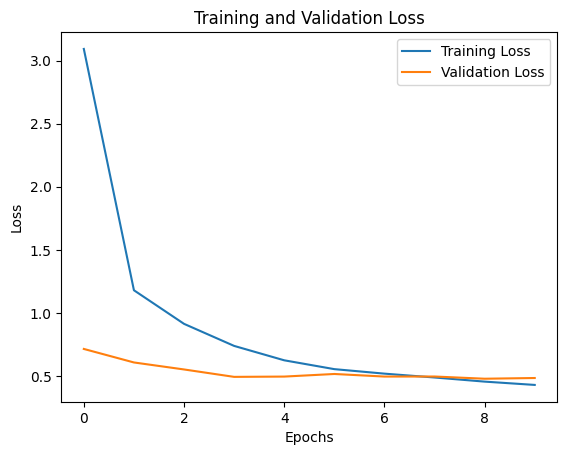

In [157]:
plot_training_curves(history_tfidf)

Doesn't look like there's much of an improvement in mere loss, but it seems that the overfitting is much better (the two curves almost overlap in the latter epochs).

Let's run a final evaluation to see what's what.

In [158]:
loss_1, mse_1= model_1gram.evaluate(test_dataset_prep_1gram)
print(f"1-gram Model - MSE: {mse_1:.4f}")

loss_2, mse_2 = model_2gram.evaluate(test_dataset_prep_2gram)
print(f"2-gram model 2 - MSE: {mse_2:.4f}")

loss_tfidf, mse_tfidf = model_tfidf.evaluate(test_dataset_prep_tfidf)
print(f"2-gram TF-IDF Model 2 - MSE: {mse_tfidf:.4f}")

235/235 [==============================] - 5s 20ms/step - loss: 0.5093 - mse: 0.5093
1-gram Model - MSE: 0.5093
235/235 [==============================] - 5s 22ms/step - loss: 0.4507 - mse: 0.4507
2-gram model 2 - MSE: 0.4507
235/235 [==============================] - 6s 23ms/step - loss: 0.4665 - mse: 0.4665
2-gram TF-IDF Model 2 - MSE: 0.4665


That's interesting: it doesn't seem like adding TF-IDF changed much at all (actually, it seems to have worsened performance).

Nevertheless, because there's much less overfitting, I'd dare declare it the winner: if I had to choose one model to simply train for longer and on more data, I'd almost surely go for the 2-gram TF-IDF one.

## (Excursus) Could using the additional data provided by Yelp help make our model better?

In [159]:
rich_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   review_id     100000 non-null  object 
 1   user_id       100000 non-null  object 
 2   business_id   100000 non-null  object 
 3   stars         100000 non-null  float64
 4   text          100000 non-null  object 
 5   date          100000 non-null  object 
 6   name          100000 non-null  object 
 7   address       100000 non-null  object 
 8   city          100000 non-null  object 
 9   state         100000 non-null  object 
 10  postal_code   100000 non-null  object 
 11  latitude      100000 non-null  float64
 12  longitude     100000 non-null  float64
 13  review_count  100000 non-null  int64  
 14  is_open       100000 non-null  int64  
 15  attributes    98369 non-null   object 
 16  categories    99996 non-null   object 
 17  hours         94176 non-null   object 
dtypes: fl

We have plenty of information, but a lot of it is useless/confounding.
 - the 'useful', 'funny' and 'cool' columns contain information about the review itself, i.e. they're obtained posterior to the stars, so we should remove them (and we already did so in the beginning)
 - the 'date' column should be eliminated to remove spurious correlations (there might be a relationship between date and stars, but it's definitely not one we want to learn)
 - the 'name', 'address', 'city', 'state' and 'postal_code' columns should be eliminated because their information is contained in the 'latitude' and 'longitude' columns, so they're redundant
 - the 'is_open' column could be useful as a filtering step (i.e. we might only want to perform sentiment analysis on open businesses), but for simplification I'll drop it
 - the 'categories' column could also used as a filtering step (as it is on Kaggle, e.g. https://www.kaggle.com/code/niyamatalmass/finding-the-perfect-restaurants-on-yelp), but for simplification I'll drop it
 - the 'hours' column is as above, so I'll drop it as well

 At the end of the day we only provisionally keep the 'text', 'latitude', 'longitude', 'review_count' and 'attributes' columns for our features (and, clearly, the 'stars' column as labels)...

 Before our final decision, though, it's useful to get a bit more precise. Let's check out the correlation matrix of the columns we left in.

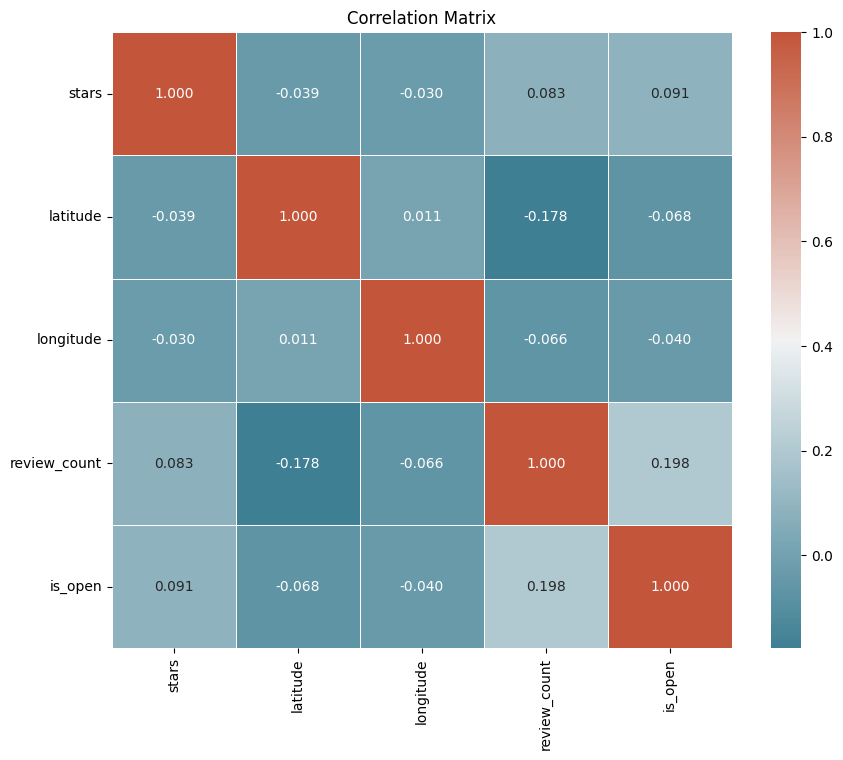

In [160]:
# compute the correlation matrix of the various numerical attributes
numeric_columns = rich_df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_columns.corr()

# set color palette
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Plot the correlation matrix with highlighted 'stars' column
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap=cmap, annot=True, fmt=".3f", linewidths=0.5, cbar=True)

plt.title("Correlation Matrix")

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()


It seems like the 'review_count', 'latitude' and 'longitude' columns are not that significant after all... Let's check it with a scatter plot.

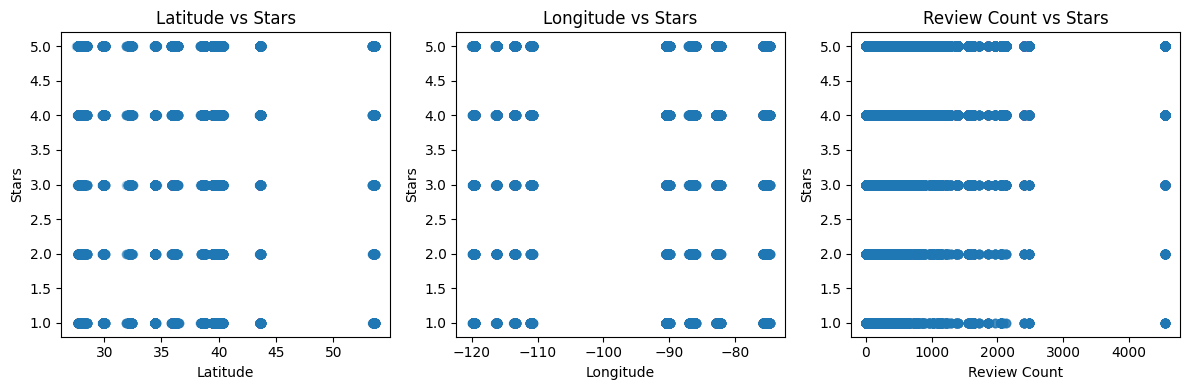

In [161]:
# create a scatter plot for latitude vs stars
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(rich_df['latitude'], rich_df['stars'], alpha=0.3)
plt.xlabel('Latitude')
plt.ylabel('Stars')
plt.title('Latitude vs Stars')

# create a scatter plot for longitude vs stars
plt.subplot(132)
plt.scatter(rich_df['longitude'], rich_df['stars'], alpha=0.3)
plt.xlabel('Longitude')
plt.ylabel('Stars')
plt.title('Longitude vs Stars')

# create a scatter plot for review_count vs stars
plt.subplot(133)
plt.scatter(rich_df['review_count'], rich_df['stars'], alpha=0.3)
plt.xlabel('Review Count')
plt.ylabel('Stars')
plt.title('Review Count vs Stars')

plt.tight_layout()

plt.show()

Oh wow, entirely horizontal... It seems that only the 'attributes' column is left, then.

In [162]:
X = rich_df[['text', 'attributes']]
y = rich_df['stars']

In [163]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        100000 non-null  object
 1   attributes  98369 non-null   object
dtypes: object(2)
memory usage: 1.5+ MB


The 'attributes' column looks intuitively interesting to me, and I already have an interesting idea as to how to use it (i.e. I'd like to learn some embeddings based on its contents and substitute the column with the latent values of this embedding).

But, to avoid useless work, it's a good idea to try to estimate its importance, or at least its viability in our context. The problem, in this case, is that this columns is not numerical (it actually containes nested JSON objects)...

In [164]:
X.iloc[0].attributes

{'NoiseLevel': "u'average'",
 'HasTV': 'False',
 'RestaurantsAttire': "'casual'",
 'BikeParking': 'False',
 'Ambience': "{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': True}",
 'WiFi': "'free'",
 'DogsAllowed': 'False',
 'Alcohol': "'none'",
 'BusinessAcceptsCreditCards': 'True',
 'RestaurantsGoodForGroups': 'True',
 'RestaurantsPriceRange2': '2',
 'RestaurantsReservations': 'False',
 'WheelchairAccessible': 'True',
 'BusinessAcceptsBitcoin': 'False',
 'RestaurantsTableService': 'True',
 'GoodForKids': 'True',
 'Caters': 'False',
 'HappyHour': 'False',
 'RestaurantsDelivery': 'True',
 'GoodForMeal': "{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': False, 'brunch': True, 'breakfast': True}",
 'OutdoorSeating': 'True',
 'RestaurantsTakeOut': 'True',
 'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}"}

In [165]:
# let's try to flatten the column and see what we're working with...
def flatten_json_columns(df, columns):
    for col in columns:
        df_normalized = pd.json_normalize(df[col])
        df = df.drop(columns=[col])
        df = pd.concat([df, df_normalized], axis=1)
    return df

X = flatten_json_columns(X, ['attributes'])
# need to flatten further because of the extra nesting
X = flatten_json_columns(
    X, ['Ambience', 'GoodForMeal', 'BusinessParking'])

In [166]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   text                        100000 non-null  object
 1   NoiseLevel                  73115 non-null   object
 2   HasTV                       72629 non-null   object
 3   RestaurantsAttire           70807 non-null   object
 4   BikeParking                 83583 non-null   object
 5   WiFi                        80187 non-null   object
 6   DogsAllowed                 42427 non-null   object
 7   Alcohol                     73054 non-null   object
 8   BusinessAcceptsCreditCards  94663 non-null   object
 9   RestaurantsGoodForGroups    72738 non-null   object
 10  RestaurantsPriceRange2      90112 non-null   object
 11  RestaurantsReservations     72372 non-null   object
 12  WheelchairAccessible        36623 non-null   object
 13  BusinessAcceptsBitcoin      21

That added a whole lot of columns, and most of them with plenty of nulls...

In [167]:
null_counts = X.isnull().sum()
sorted_columns = null_counts.sort_values() # sort columns based on number of null values in each

X[sorted_columns.index].info() # by the 18th column we're already at 60% of values being null!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   text                        100000 non-null  object
 1   BusinessAcceptsCreditCards  94663 non-null   object
 2   RestaurantsPriceRange2      90112 non-null   object
 3   BikeParking                 83583 non-null   object
 4   WiFi                        80187 non-null   object
 5   GoodForKids                 77828 non-null   object
 6   RestaurantsTakeOut          77366 non-null   object
 7   RestaurantsDelivery         75632 non-null   object
 8   OutdoorSeating              74694 non-null   object
 9   NoiseLevel                  73115 non-null   object
 10  Alcohol                     73054 non-null   object
 11  RestaurantsGoodForGroups    72738 non-null   object
 12  HasTV                       72629 non-null   object
 13  RestaurantsReservations     72

Indeed: take a look at those few final columns!

At this point we have two choices: we either leave the 'attributes' in, and engage in some **serious** data cleaning and feature engineering, or we dont. 

I'll opt for the second choice because 1) that would require quite a bit of time and, although interesting, would mostly be out of scope for the current project, and 2) intuitively speaking, a lot of this information should be in the review text itself, so the model probably already takes it into account.

In conclusion, it seems our initial approach of only utilising the text was a reasonable one, which is certainly quite comforting if nothing else.

## Time to get serious: let's use RNNs!

### Data preparation (repeated here for convenience)

In [3]:
# adjust the kwarg 'max_nl' depending on how much time you're willing to wait and how much RAM is available (leave None if you want to read the whole file)
def read_to_dataframe(file, max_nl=None):
  with open(file, 'r') as f:
    data = [json.loads(line) for line in f] if max_nl is None else [json.loads(next(f)) for _ in range(max_nl)]

  return pd.DataFrame(data)

def create_datasets(df, feature_columns, label_column, train_size, test_size, random_state=None):
    X = df[feature_columns]
    y = df[label_column]

    # we use stratification to mantain similar proportions across the various splits (the distribution is quite asymmetrical, after all)
    X_train, X_test_val, y_train, y_test_val = train_test_split(
        X, y, train_size=train_size, stratify=y, random_state=random_state)

    X_val, X_test, y_val, y_test = train_test_split(
        X_test_val, y_test_val, test_size=test_size, stratify=y_test_val, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

def prepare_for_model(train_dataset, val_dataset, test_dataset, m, preprocess_fn, batch_size=64):
    # apply the preprocessing pipeline to the datasets
    train_dataset_prepepared = train_dataset.map(
        lambda review, label: (preprocess_fn(review), label))
    val_dataset_prepared = val_dataset.map(
        lambda review, label: (preprocess_fn(review), label))
    test_dataset_prepared = test_dataset.map(
        lambda review, label: (preprocess_fn(review), label))

    # shuffle and batch the training dataset
    train_dataset_prepepared = train_dataset_prepepared.shuffle(m).batch(batch_size)

    # batch the validation and testing datasets
    val_dataset_prepared = val_dataset_prepared.batch(batch_size)
    test_dataset_prepared = test_dataset_prepared.batch(batch_size)

    return train_dataset_prepepared, val_dataset_prepared, test_dataset_prepared


In [4]:
data_dir = "yelp-data/" # splitting data up like this might be useful for later (in case i want to use other files)
vocabulary_size = 30_000
train_size = 0.7 # the percentage of data reserved for training
test_size = 0.5 # the percentage of data reserved for testing (from the data that remains)
n_epochs = 10 # adjust this if the model trains too slowly (or modify model parameters as desired...)

In [6]:
review_file = "yelp_academic_dataset_review.json"
review_df = read_to_dataframe(data_dir + review_file, max_nl=100_000)

business_file = "yelp_academic_dataset_business.json"
business_df = read_to_dataframe(data_dir + business_file)
business_df.drop(["stars"], axis=1, inplace=True)

rich_df = pd.merge(review_df, business_df, on="business_id")

X_train, X_val, X_test, y_train, y_val, y_test = create_datasets(
    rich_df, 'text', 'stars', train_size, test_size, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Create TensorFlow datasets for the training, validatoin and test data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Training set shape: (70000,) (70000,)
Validation set shape: (15000,) (15000,)
Testing set shape: (15000,) (15000,)


The preparation of the `TextVectorization` and of the dataset should be repeated though!

In [7]:
# compute the maximum review length (useful for later padding)
max_length = max(rich_df['text'].apply(lambda x: len(x.split())))

text_vectorization_rnn = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_mode='int', # i.e. each sentence will be a vector of ints (where each int is associated to a word)
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_sequence_length=max_length,
)

In [8]:
text_vectorization_rnn.adapt(train_dataset.map(lambda review, label: review))

In [9]:
text_vectorization_rnn.get_vocabulary()

['',
 '[UNK]',
 'the',
 'and',
 'a',
 'i',
 'to',
 'was',
 'of',
 'is',
 'it',
 'for',
 'in',
 'my',
 'we',
 'with',
 'that',
 'but',
 'this',
 'they',
 'on',
 'you',
 'had',
 'have',
 'not',
 'were',
 'food',
 'so',
 'good',
 'are',
 'place',
 'at',
 'great',
 'be',
 'as',
 'very',
 'there',
 'our',
 'all',
 'if',
 'out',
 'here',
 'me',
 'service',
 'just',
 'like',
 'its',
 'time',
 'one',
 'get',
 'their',
 'from',
 'back',
 'would',
 'or',
 'when',
 'an',
 'go',
 'really',
 'up',
 'which',
 'about',
 'will',
 'been',
 'some',
 'also',
 'what',
 'only',
 'more',
 'no',
 'she',
 'your',
 'can',
 'us',
 'nice',
 'best',
 'got',
 'he',
 'by',
 'well',
 'because',
 'them',
 'dont',
 'even',
 'too',
 'staff',
 'other',
 'ordered',
 'love',
 'im',
 'ive',
 'friendly',
 'has',
 'delicious',
 'always',
 'do',
 'after',
 'order',
 'restaurant',
 'little',
 'chicken',
 'than',
 'try',
 'definitely',
 'came',
 'first',
 'didnt',
 'menu',
 'did',
 'went',
 'could',
 'never',
 'much',
 'amazing

In [10]:
train_dataset_prep_rnn, val_dataset_prep_rnn, test_dataset_prep_rnn = prepare_for_model(
    train_dataset, val_dataset, test_dataset, len(X_train), text_vectorization_rnn)

### Let's define our first RNN model!

Our model will be a bidirectional LSTM-based model.

Bidirectionality means that the model traverses the sequence (i.e. our vector as obtained after passing it through the `TextVectorization` layer) in both directions (first from left to right then vice versa).

LSTM because we saw how bigrams did provide an improvement to our models, which indicates (unsurprisignly) that order matters and that local information is important, and LSTM are able to keep track of order information for quite a bit longer than standard RNNs (that's precisely why they're called **Long** Short Term Memory, after all).

In [11]:
def create_LSTM_model(max_length, num_words):
    inputs = layers.Input(shape=(max_length,), dtype="int64")

    one_hot = tf.one_hot(inputs, depth=num_words) # for simplicity
    lstm = layers.Bidirectional(layers.LSTM(32))(one_hot)
    outputs = layers.Dense(1)(lstm)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mse'])
    
    return model

In [12]:
lstm_model = create_LSTM_model(max_length, vocabulary_size)

In [13]:
lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1006)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, 1006, 30000)       0         
                                                                 
 bidirectional (Bidirection  (None, 64)                7688448   
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 7688513 (29.33 MB)
Trainable params: 7688513 (29.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm",
                                    save_best_only=True)
]

# this takes A LOT longer than our previous models...
history_lstm = lstm_model.fit(
    train_dataset_prep_rnn,
    validation_data=val_dataset_prep_rnn, 
    epochs=n_epochs//2,
    callbacks=callbacks)

Epoch 1/5


   1/1094 [..............................] - ETA: 8:50:20 - loss: 17.0464 - mse: 17.0464

KeyboardInterrupt: 

That is some incredibly slow training... Is there any hope of training the model with the little compute offered us by the Colab environment? Why yes!

There are two additions we can make to our model to speed it up: use a `Conv1D` layer instead of RNNs and use an `Embedding` layer instead of `tf.one_hot()`.

The idea of using a `Conv1D` is absolutely brilliant and is entirely due to Chollet[Book ref]: it still takes care of local information (because it convolves the 1D kernel over the whole vector), and it still considers ordering (because convolution is not an order agnostic operation). Obviously we lose any form of memory, but maybe that's not too bad.

We'll have more to say on Embeddings later on.

### Let's try a Conv1D based model.

In [15]:
def create_conv1d_model(max_length, num_words):
    inputs = layers.Input(shape=(max_length,), dtype="int64")

    one_hot = tf.one_hot(inputs, num_words)
    conv1d = layers.Conv1D(32, 3, activation='relu')(one_hot)
    pool = layers.GlobalMaxPooling1D()(conv1d)

    outputs = layers.Dense(1)(pool)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mse'])
    
    return model

In [16]:
conv1d_model = create_conv1d_model(max_length, vocabulary_size)

In [17]:
conv1d_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1006)]            0         
                                                                 
 tf.one_hot_1 (TFOpLambda)   (None, 1006, 30000)       0         
                                                                 
 conv1d (Conv1D)             (None, 1004, 32)          2880032   
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2880065 (10.99 MB)
Trainable params: 2880065 (10.99 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_conv1d",
                                    save_best_only=True)
]

# that's quite a bit better!
history_conv1d = conv1d_model.fit(
    # no additional preparation needed!
    train_dataset_prep_rnn,
    validation_data=val_dataset_prep_rnn, 
    epochs=n_epochs//2,
    callbacks=callbacks)

Epoch 1/5
   4/1094 [..............................] - ETA: 1:11:20 - loss: 16.6627 - mse: 16.6627

KeyboardInterrupt: 

Not bad: One my M1 Pro I see a 7x speed-up!

Now for the last addition: using an `Embedding` layer. In the code above, we used text vectorization to encode our sentences as integer vectors, but we haven't used this at all, because our space was still 30k dimensional (the `vocabulary_size`), and our model operated in that high-dimensional latent space.

Using embeddings, one the other hand, we can operate on a much lower dimensional space, thus speed up the model. In our case, the `Embedding` layer will be trainable as well, so we'll train the embeddings as we go, but we could probably speed up the process further if we used pre-trained embeddings (e.g. GloVe, or word2vec).

Naturally on top of the dimensionality concern we also get an advantage of operating in a semantically meaningful latent space, but that's an interesting topic that's out of scope for the current project.

### And use trained embeddings.

In [19]:
def create_conv1d_embed_model(max_length, num_words):
    inputs = layers.Input(shape=(max_length,), dtype="int64")

    embed = layers.Embedding(input_dim=num_words, output_dim=256)(inputs)
    conv1d = layers.Conv1D(32, 3, activation='relu')(embed)
    pool = layers.GlobalMaxPooling1D()(conv1d)

    outputs = layers.Dense(1)(pool)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mse'])
    
    return model

In [26]:
conv1d_embed_model = create_conv1d_embed_model(max_length, vocabulary_size)

In [27]:
conv1d_embed_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1006)]            0         
                                                                 
 embedding_2 (Embedding)     (None, 1006, 256)         7680000   
                                                                 
 conv1d_3 (Conv1D)           (None, 1004, 32)          24608     
                                                                 
 global_max_pooling1d_3 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7704641 (29.39 MB)
Trainable params: 7704641 (29.39 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [28]:
callbacks = [
    keras.callbacks.ModelCheckpoint("conv1d_embed",
                                    save_best_only=True)
]

# much better!
history_conv1d_embed = conv1d_embed_model.fit(
    # once again, no further preparation needed (as a matter of fact, the data has been prepared for embedding all along)
    train_dataset_prep_rnn,
    validation_data=val_dataset_prep_rnn, 
    epochs=n_epochs//2,
    callbacks=callbacks)

Epoch 1/5
1094/1094 [==============================] - ETA: 0s - loss: 1.0579 - mse: 1.0579INFO:tensorflow:Assets written to: conv1d_embed/assets


INFO:tensorflow:Assets written to: conv1d_embed/assets


1094/1094 [==============================] - 89s 75ms/step - loss: 1.0579 - mse: 1.0579 - val_loss: 0.5672 - val_mse: 0.5672
Epoch 2/5
1094/1094 [==============================] - ETA: 0s - loss: 0.4719 - mse: 0.4719INFO:tensorflow:Assets written to: conv1d_embed/assets


INFO:tensorflow:Assets written to: conv1d_embed/assets


1094/1094 [==============================] - 85s 72ms/step - loss: 0.4719 - mse: 0.4719 - val_loss: 0.5412 - val_mse: 0.5412
Epoch 3/5
1094/1094 [==============================] - 86s 74ms/step - loss: 0.3433 - mse: 0.3433 - val_loss: 0.5526 - val_mse: 0.5526
Epoch 4/5
1094/1094 [==============================] - 84s 72ms/step - loss: 0.2551 - mse: 0.2551 - val_loss: 0.5662 - val_mse: 0.5662
Epoch 5/5
1094/1094 [==============================] - 87s 74ms/step - loss: 0.1949 - mse: 0.1949 - val_loss: 0.5815 - val_mse: 0.5815


Now that's a whole lot better! Let's check the training curves.

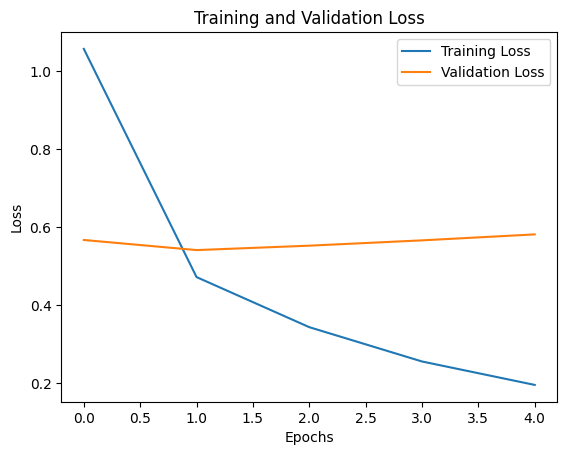

In [30]:
def plot_training_curves(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()

plot_training_curves(history_conv1d_embed)

That's some serious overfitting!

And let's evaluate it.

In [31]:
loss, mse = conv1d_embed_model.evaluate(test_dataset_prep_rnn)
print(f"1-gram Model - MSE: {mse:.4f}")

235/235 [==============================] - 4s 17ms/step - loss: 0.5973 - mse: 0.5973
1-gram Model - MSE: 0.5973


That's the worst model so far... 

Was it all for naught? Well, for one, this model was only trained on half the epochs. For two, there are quite a few more hyperparametres to manage here than in the FFN case, but I mostly set them to "default" values. Finally, the model is much shallower than the FFN one.

At the same time, this result seems to match what Chollet found empirically[Choller ratio reference], so it isn't that surprising after all.

That said, let's try the hot new model on the block as a last experiment. Let's play around with Transformers.

## Going even further: Transformers! 

### Data preparation (repeated here for convenience)

In [32]:
# adjust the kwarg 'max_nl' depending on how much time you're willing to wait and how much RAM is available (leave None if you want to read the whole file)
def read_to_dataframe(file, max_nl=None):
  with open(file, 'r') as f:
    data = [json.loads(line) for line in f] if max_nl is None else [json.loads(next(f)) for _ in range(max_nl)]

  return pd.DataFrame(data)

def create_datasets(df, feature_columns, label_column, train_size, test_size, random_state=None):
    X = df[feature_columns]
    y = df[label_column]

    # we use stratification to mantain similar proportions across the various splits (the distribution is quite asymmetrical, after all)
    X_train, X_test_val, y_train, y_test_val = train_test_split(
        X, y, train_size=train_size, stratify=y, random_state=random_state)

    X_val, X_test, y_val, y_test = train_test_split(
        X_test_val, y_test_val, test_size=test_size, stratify=y_test_val, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

def prepare_for_model(train_dataset, val_dataset, test_dataset, m, preprocess_fn, batch_size=64):
    # apply the preprocessing pipeline to the datasets
    train_dataset_prepepared = train_dataset.map(
        lambda review, label: (preprocess_fn(review), label))
    val_dataset_prepared = val_dataset.map(
        lambda review, label: (preprocess_fn(review), label))
    test_dataset_prepared = test_dataset.map(
        lambda review, label: (preprocess_fn(review), label))

    # shuffle and batch the training dataset
    train_dataset_prepepared = train_dataset_prepepared.shuffle(m).batch(batch_size)

    # batch the validation and testing datasets
    val_dataset_prepared = val_dataset_prepared.batch(batch_size)
    test_dataset_prepared = test_dataset_prepared.batch(batch_size)

    return train_dataset_prepepared, val_dataset_prepared, test_dataset_prepared


In [33]:
data_dir = "yelp-data/" # splitting data up like this might be useful for later (in case i want to use other files)
vocabulary_size = 30_000
train_size = 0.7 # the percentage of data reserved for training
test_size = 0.5 # the percentage of data reserved for testing (from the data that remains)
n_epochs = 10 # adjust this if the model trains too slowly (or modify model parameters as desired...)

In [34]:
review_file = "yelp_academic_dataset_review.json"
review_df = read_to_dataframe(data_dir + review_file, max_nl=100_000)

business_file = "yelp_academic_dataset_business.json"
business_df = read_to_dataframe(data_dir + business_file)
business_df.drop(["stars"], axis=1, inplace=True)

rich_df = pd.merge(review_df, business_df, on="business_id")

X_train, X_val, X_test, y_train, y_val, y_test = create_datasets(
    rich_df, 'text', 'stars', train_size, test_size, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Create TensorFlow datasets for the training, validatoin and test data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Training set shape: (70000,) (70000,)
Validation set shape: (15000,) (15000,)
Testing set shape: (15000,) (15000,)


The preparation of the `TextVectorization` and of the dataset should be repeated though!

In [37]:
# compute the maximum review length (useful for later padding)
max_length = max(rich_df['text'].apply(lambda x: len(x.split())))

text_vectorization_transf = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_mode='int', # i.e. each sentence will be a vector of ints (where each int is associated to a word)
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_sequence_length=max_length,
)

In [38]:
text_vectorization_transf.adapt(train_dataset.map(lambda review, label: review))

In [39]:
text_vectorization_transf.get_vocabulary()

['',
 '[UNK]',
 'the',
 'and',
 'a',
 'i',
 'to',
 'was',
 'of',
 'is',
 'it',
 'for',
 'in',
 'my',
 'we',
 'with',
 'that',
 'but',
 'this',
 'they',
 'on',
 'you',
 'had',
 'have',
 'not',
 'were',
 'food',
 'so',
 'good',
 'are',
 'place',
 'at',
 'great',
 'be',
 'as',
 'very',
 'there',
 'our',
 'all',
 'if',
 'out',
 'here',
 'me',
 'service',
 'just',
 'like',
 'its',
 'time',
 'one',
 'get',
 'their',
 'from',
 'back',
 'would',
 'or',
 'when',
 'an',
 'go',
 'really',
 'up',
 'which',
 'about',
 'will',
 'been',
 'some',
 'also',
 'what',
 'only',
 'more',
 'no',
 'she',
 'your',
 'can',
 'us',
 'nice',
 'best',
 'got',
 'he',
 'by',
 'well',
 'because',
 'them',
 'dont',
 'even',
 'too',
 'staff',
 'other',
 'ordered',
 'love',
 'im',
 'ive',
 'friendly',
 'has',
 'delicious',
 'always',
 'do',
 'after',
 'order',
 'restaurant',
 'little',
 'chicken',
 'than',
 'try',
 'definitely',
 'came',
 'first',
 'didnt',
 'menu',
 'did',
 'went',
 'could',
 'never',
 'much',
 'amazing

In [49]:
train_dataset_prep_transf, val_dataset_prep_transf, test_dataset_prep_transf = prepare_for_model(
    train_dataset, val_dataset, test_dataset, len(X_train), text_vectorization_transf)

### Let's define a transformer encoder.

The code below is taken directly from Chollet's book, and commented throughout for clarity.
TODO: insert image here

In [50]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, n_heads, **kwargs):
        super().__init__(**kwargs)

        self.embed_dim = embed_dim # size of input tokens
        self.dense_dim = dense_dim # size of inner dense layer
        self.n_heads = n_heads

        self.attention = layers.MultiHeadAttention(
            num_heads=n_heads, key_dim=embed_dim)

        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim),]
        )

        self.layernorm_1 = layers.LayerNormalization() # works better than BatchNormalization, for textual data
        self.layernorm_2 = layers.LayerNormalization()

    # The call function does the actual computation, i.e. it's called when we do TransformerEncoder(...).
    def call(self, inputs, mask=None): 
        if mask is not None:
            # the Embedding layer will create a 2D mask, the attention layer needs it to be 3D or 4D 
            mask = mask[:, tf.newaxis, :]

        # the code below simply passes the input through all the components of the encoder, as specified by the diagram
        attention_output = self.attention(inputs, inputs, attention_mask=mask)

        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)

        return self.layernorm_2(proj_input + proj_output)

    # The get_config function serves serialization purposes, i.e. allows us to save and load the model.
    def get_config(self):
        config = super().get_config() 

        config.update({
            "embed_dim": self.embed_dim,
            "n_heads": self.n_heads,
            "dense_dim": self.dense_dim,
        })

        return config

Let's create a model only using the `TransformerEncoder` used above.

NOTE: We don't need a decoder because our model isn't seq2seq. (Also, as a fun bit of trivia, GPT is also just a stack of encoders[proof ref]).

In [51]:
def create_transformer_model(vocabulary_size, embed_dim, n_heads, dense_dim):
    inputs = keras.Input(shape=(None,), dtype="int64")

    x = layers.Embedding(vocabulary_size, embed_dim)(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, n_heads)(x)
    x = layers.GlobalMaxPooling1D()(x) # the encoder will return sequences, but we need a single vector, so we flatten the seq with a pooling layer
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)

    model.compile(optimizer="adam",
                loss="mean_squared_error",
                metrics=["mse"])

    return model

In [52]:
transformer_model = create_transformer_model(vocabulary_size, 256, 2, 32)

In [53]:
transformer_model.summary() # even with a single transformer encoder we get >8M parameters!

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_5 (Embedding)     (None, None, 256)         7680000   
                                                                 
 transformer_encoder_2 (Tra  (None, None, 256)         543776    
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d_6 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 257 

In [54]:
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder",
                                    save_best_only=True)
]

# slow, but still faster than biderectional RNNs!
transformer_history = transformer_model.fit(
    train_dataset_prep_transf,
    validation_data=val_dataset_prep_transf,
    epochs=n_epochs//2,
    callbacks=callbacks)

Epoch 1/5


   7/1094 [..............................] - ETA: 40:54 - loss: 16.2380 - mse: 16.2380

KeyboardInterrupt: 

The training proceeds rather slowly (but still much faster than our bidirectional LSTM model).

There's a bigger problem though: we've completely ignored positional information. We can easily remedy this, though. (As for the `TransformerEncoder` the code below is taken from Chollet[book ref])

In [55]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)

        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        # this will keep track of position
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)

        self.sequence_length = sequence_length 
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)

        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)

        # add both embeddings => i.e. add positional information to our tokens
        return embedded_tokens + embedded_positions

    # This function allows use to compute a mask, which in turn allows us to save on computation (we don't do anythin when this mask is zero, so we don't need to process the padding).
    # It will be called automatically and managed by keras.
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config() 

        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })

        return config

In [56]:
def create_pos_transformer_model(vocabulary_size, max_length, embed_dim, n_heads, dense_dim):
    inputs = keras.Input(shape=(None,), dtype="int64")

    x = PositionalEmbedding(max_length, vocabulary_size, embed_dim)(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, n_heads)(x)
    x = layers.GlobalMaxPooling1D()(x) # the encoder will return sequences, but we need a single vector, so we flatten the seq with a pooling layer
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)

    model.compile(optimizer="adam",
                loss="mean_squared_error",
                metrics=["mse"])

    return model

In [57]:
pos_transformer_model = create_pos_transformer_model(vocabulary_size, max_length, 256, 2, 32)

In [58]:
pos_transformer_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posi  (None, None, 256)         7937536   
 tionalEmbedding)                                                
                                                                 
 transformer_encoder_3 (Tra  (None, None, 256)         543776    
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d_7 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                           

In [60]:
callbacks = [
    keras.callbacks.ModelCheckpoint("pos_transformer_encoder",
                                    save_best_only=True)
]

# adding the positional embedding only makes the model a little slower, good news!
pos_transformer_history = pos_transformer_model.fit(
    train_dataset_prep_transf,
    validation_data=val_dataset_prep_transf,
    epochs=n_epochs//2,
    callbacks=callbacks)

Epoch 1/5
  19/1094 [..............................] - ETA: 39:22 - loss: 8.3062 - mse: 8.3062

KeyboardInterrupt: 

That made the model a bit faster even. Interesting! It is still quite slow, though.

## Back to Bag-of-Words: Fine-tuning edition.

Ok, so we've looked at a good deal of different architectures so far, but we only trained one alternative, the `Conv1D` + `Embedding` model, simply because it was the quickest to train. Naturally, if we had the patience/compute we could also train the rest. 

But, in this case, our bigram TF-IDF Bag-of-Words model seemed to perform quite well, so why not spend some time fine-tuning it instead? This is exactly what we'll be doing in this (final) section.

### Data preparation (repeated here for convenience)

In [61]:
# adjust the kwarg 'max_nl' depending on how much time you're willing to wait and how much RAM is available (leave None if you want to read the whole file)
def read_to_dataframe(file, max_nl=None):
  with open(file, 'r') as f:
    data = [json.loads(line) for line in f] if max_nl is None else [json.loads(next(f)) for _ in range(max_nl)]

  return pd.DataFrame(data)

def create_datasets(df, feature_columns, label_column, train_size, test_size, random_state=None):
    X = df[feature_columns]
    y = df[label_column]

    # we use stratification to mantain similar proportions across the various splits (the distribution is quite asymmetrical, after all)
    X_train, X_test_val, y_train, y_test_val = train_test_split(
        X, y, train_size=train_size, stratify=y, random_state=random_state)

    X_val, X_test, y_val, y_test = train_test_split(
        X_test_val, y_test_val, test_size=test_size, stratify=y_test_val, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

def prepare_for_model(train_dataset, val_dataset, test_dataset, m, preprocess_fn, batch_size=64):
    # apply the preprocessing pipeline to the datasets
    train_dataset_prepepared = train_dataset.map(
        lambda review, label: (preprocess_fn(review), label))
    val_dataset_prepared = val_dataset.map(
        lambda review, label: (preprocess_fn(review), label))
    test_dataset_prepared = test_dataset.map(
        lambda review, label: (preprocess_fn(review), label))

    # shuffle and batch the training dataset
    train_dataset_prepepared = train_dataset_prepepared.shuffle(m).batch(batch_size)

    # batch the validation and testing datasets
    val_dataset_prepared = val_dataset_prepared.batch(batch_size)
    test_dataset_prepared = test_dataset_prepared.batch(batch_size)

    return train_dataset_prepepared, val_dataset_prepared, test_dataset_prepared


In [62]:
data_dir = "yelp-data/" # splitting data up like this might be useful for later (in case i want to use other files)
vocabulary_size = 30_000
train_size = 0.7 # the percentage of data reserved for training
test_size = 0.5 # the percentage of data reserved for testing (from the data that remains)
n_epochs = 10 # adjust this if the model trains too slowly (or modify model parameters as desired...)

In [63]:
review_file = "yelp_academic_dataset_review.json"
review_df = read_to_dataframe(data_dir + review_file, max_nl=100_000)

business_file = "yelp_academic_dataset_business.json"
business_df = read_to_dataframe(data_dir + business_file)
business_df.drop(["stars"], axis=1, inplace=True)

rich_df = pd.merge(review_df, business_df, on="business_id")

X_train, X_val, X_test, y_train, y_val, y_test = create_datasets(
    rich_df, 'text', 'stars', train_size, test_size, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Create TensorFlow datasets for the training, validatoin and test data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Training set shape: (70000,) (70000,)
Validation set shape: (15000,) (15000,)
Testing set shape: (15000,) (15000,)


### Quickly define model and stuff below here

### We can start tuning parameters in the `TextVectorization` layer already.

Two parameters looks amenable to fine-tuning: the `max_tokens` and the `ngrams`.

To make experimentation easier and more comfortable, it's a good idea to enclose the vectorization procedure in a function.

In [ ]:
def vectorize(ngrams, vocabulary_size):
    text_vectorization_tfidf = layers.TextVectorization(
        ngrams=ngrams,
        max_tokens=vocabulary_size,

        output_mode='tf_idf', # once again, it's that simple
        standardize='lower_and_strip_punctuation',
        split='whitespace',
    )

    text_vectorization_tfidf.adapt(train_dataset.map(lambda review, label: review))

    return text_vectorization_tfidf

In [ ]:
text_vectorization_transf.get_vocabulary()

['',
 '[UNK]',
 'the',
 'and',
 'a',
 'i',
 'to',
 'was',
 'of',
 'is',
 'it',
 'for',
 'in',
 'my',
 'we',
 'with',
 'that',
 'but',
 'this',
 'they',
 'on',
 'you',
 'had',
 'have',
 'not',
 'were',
 'food',
 'so',
 'good',
 'are',
 'place',
 'at',
 'great',
 'be',
 'as',
 'very',
 'there',
 'our',
 'all',
 'if',
 'out',
 'here',
 'me',
 'service',
 'just',
 'like',
 'its',
 'time',
 'one',
 'get',
 'their',
 'from',
 'back',
 'would',
 'or',
 'when',
 'an',
 'go',
 'really',
 'up',
 'which',
 'about',
 'will',
 'been',
 'some',
 'also',
 'what',
 'only',
 'more',
 'no',
 'she',
 'your',
 'can',
 'us',
 'nice',
 'best',
 'got',
 'he',
 'by',
 'well',
 'because',
 'them',
 'dont',
 'even',
 'too',
 'staff',
 'other',
 'ordered',
 'love',
 'im',
 'ive',
 'friendly',
 'has',
 'delicious',
 'always',
 'do',
 'after',
 'order',
 'restaurant',
 'little',
 'chicken',
 'than',
 'try',
 'definitely',
 'came',
 'first',
 'didnt',
 'menu',
 'did',
 'went',
 'could',
 'never',
 'much',
 'amazing

In [ ]:
train_dataset_prep_transf, val_dataset_prep_transf, test_dataset_prep_transf = prepare_for_model(
    train_dataset, val_dataset, test_dataset, len(X_train), text_vectorization_transf)